Authors: Hofmarcher

Date: 20-03-2023

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**. 

---


# Imports

Install Gymnasium and dependencies to render the environments

In [1]:
!apt update
!apt install -y xvfb x11-utils python-opengl ffmpeg swig
!pip install gymnasium==0.27.1 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
%matplotlib inline

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
from time import time, strftime
from glob import glob
from tqdm import tqdm
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output
from IPython import display


#own imports
import time

# Select device for training

By default we train on GPU if one is available, otherwise we fall back to the CPU.
If you want to always use the CPU change accordingly.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


# Setup Google Drive mount to store your results

In [4]:
use_google_drive = False
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Download Dataset and Expert model

In [5]:
# Download training and validation datasets
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download' -O expert.onnx
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download' -O train.zip
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/3DxHLiqxTddepp8/download' -O val.zip

# Unzip datasets
!unzip -q -o train.zip
!unzip -q -o val.zip

--2023-04-16 20:05:13--  https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download
Resolving cloud.ml.jku.at (cloud.ml.jku.at)... 140.78.90.41
Connecting to cloud.ml.jku.at (cloud.ml.jku.at)|140.78.90.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6747975 (6.4M) [application/octet-stream]
Saving to: ‘expert.onnx’

expert.onnx         100%[===================>]   6.43M  11.0MB/s    in 0.6s    

2023-04-16 20:05:14 (11.0 MB/s) - ‘expert.onnx’ saved [6747975/6747975]

--2023-04-16 20:05:14--  https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download
Resolving cloud.ml.jku.at (cloud.ml.jku.at)... 140.78.90.41
Connecting to cloud.ml.jku.at (cloud.ml.jku.at)|140.78.90.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85373838 (81M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  81.42M  11.1MB/s    in 7.4s    

2023-04-16 20:05:22 (11.0 MB/s) - ‘train.zip’ saved [85373838/85373838]

--2023-04-16 20:05:22--  

# Auxiliary Methods

The following cell contains classes and functions to provide some functionality for logging, plotting and exporting your model in the format required by the submission server.
You are free to use your own logging framework if you wish (such as tensorboard or Weights & Biases).
The logger is a very simple implementation of a CSV-file based logger.
Additionally it creates a folder for each run with subfolders for model files, logs and videos.

In [6]:
class Logger():
    def __init__(self, logdir, params=None):
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")
    
    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))
    
    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None
    
    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


def plot_metrics(logger):
    train_loss  = logger.get_values("training_loss")
    train_entropy  = logger.get_values("training_entropy")
    val_loss = logger.get_values("validation_loss")
    val_acc = logger.get_values("validation_accuracy")
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131, label="train")
    ax2 = fig.add_subplot(131, label="val",frame_on=False)
    ax4 = fig.add_subplot(132, label="entropy")
    ax3 = fig.add_subplot(133, label="acc")

    ax1.plot(train_loss, color="C0")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Update (Training)", color="C0")        
    ax1.xaxis.grid(False)  
    ax1.set_ylim((0,4))

    ax2.plot(val_loss, color="C1")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel('Epoch (Validation)', color="C1")     
    ax2.xaxis.set_label_position('top')     
    ax2.xaxis.grid(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim((0,4))

    ax4.plot(train_entropy, color="C3")    
    ax4.set_xlabel('Update (Training)', color="black")     
    ax4.set_ylabel("Entropy", color="C3")
    ax4.tick_params(axis='x', colors="black")
    ax4.tick_params(axis='y', colors="black")
    ax4.xaxis.grid(False)

    ax3.plot(val_acc, color="C2")
    ax3.set_xlabel("Epoch (Validation)", color="black")
    ax3.set_ylabel("Accuracy", color="C2")
    ax3.tick_params(axis='x', colors="black")
    ax3.tick_params(axis='y', colors="black")
    ax3.xaxis.grid(False)
    ax3.set_ylim((0,1))

    fig.tight_layout(pad=2.0)
    plt.show()
    
"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(video_dir):
    mp4list = glob(f'{video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

# Dataset

Use this dataset class to load the provided demonstrations. Furthermore, this dataset has functionality to add new samples to the dataset which you will need for implementing the DAgger algorithm.

In [7]:
class DemonstrationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob(f"{data_dir}/*.npz"))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        state = data["state"][np.newaxis, ...].astype(np.float32)
        action = data["action"]
        return state / 255.0, action.item()
    
    def append(self, states, actions):
        offset = len(self) + 1
        for i in range(len(states)):
            filename = f"{self.data_dir}/{offset+i:06}.npz"
            np.savez_compressed(filename, state=states[i], action=actions[i].astype(np.int32))
            self.files.append(filename)

# Inspect data

It is always a good idea to take a look at the data when you start working with a new dataset. Feel free to investigate the dataset further on your own.

In [8]:
# Action Statistics
dataset = DemonstrationDataset("train")
print("Number of samples: {}".format(len(dataset)));

Number of samples: 49538


Action: gas


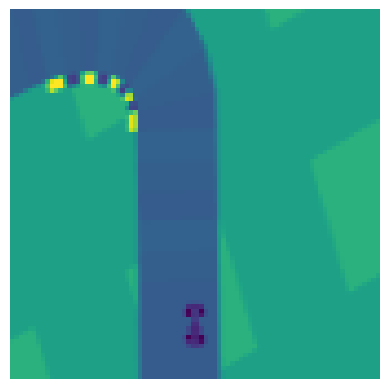

In [9]:
# Action mapping from gymnasium.farama.org
action_mapping = {
    0: "do nothing",
    1: "steer left",
    2: "steer right",
    3: "gas",
    4: "brake"
}

# Visualize random frames
idx = np.random.randint(len(dataset))
state, action = dataset[idx]
# store a single frame as we need it later for exporting an ONNX model (it needs a sample of the input for the export)
sample_state = torch.Tensor(state).unsqueeze(0).to(device)
# Display the sample
print(f"Action: {action_mapping[action]}")
plt.axis("off")
plt.imshow(state[0]);

In [10]:
# release memory
del dataset

# Define Policy Network

You need to design a neural network architecture that is capable of mapping a state to an action.
The input is a single image with the following properties:
- Resolution of 84x84 pixels
- Grayscale (meaning a single channel as opposed to three channels of an RGB image)
- The values of each pixel should be between 0 and 1

The output of the network should be one unit per possible action, as our environment has 5 actions that results in 5 output units.
Your network must implement the forward function in order to be compatible with the evaluation script.

In [11]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_units_out):
        super(PolicyNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1,5,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 41x41x5
            nn.Conv2d(5,25,3), # 39x39x25
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 19x19x25
            nn.Conv2d(25,30,3), # 17x17x50
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 8x8x50
            nn.Conv2d(30,30,3), # 6x6x50
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # 1x1x50
            nn.Flatten(),
            nn.Linear(30, 25),
            nn.ReLU(),
            nn.Linear(25, 12),
            nn.ReLU(),
            nn.Linear(12, n_units_out)
        )
        return None

    def forward(self, x):
        pred = self.layers(x)
        return pred

# Train behavioral cloning policy

Now that you have a Dataset and a network you need to train your network.
With behavioral cloning we want to imitate the behavior of the agent that produced the demonstration dataset as close as possible.
This is basically supervised learning, where you want to minimize the loss of your network on the training and validation sets.

Some tips as to what you need to implement:
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- don't forget to evaluate your network on the validation set
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

In [12]:
# choose the batchsize for training
batch_size = 64

# Datasets
train_set = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
# You can also choose to use a different logging framework such as tensorboard (not recommended on Colab) or Weights & Biases (highly recommended)
logger = Logger("logdir")
print("Saving state to {}".format(logger.basepath))

# Network
model = PolicyNetwork(n_units_out=5)
model = model.to(device)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: {}".format(num_trainable_params))

######################
### YOUR CODE HERE ###
######################
# Implement your training and evaluation loop 
# feel free to define your own functions for training and evaluation 

# If you want to export your model as an ONNX file use the following code as template
# If you use the provided logger you can use this directly
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
# optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epoch = 10

def train_model(model, data_loader, loss_fn, optim):
    model.train()
    model.cuda()
    total_loss = 0
    total_accuracy = 0
    for idx, (img, lab) in enumerate(data_loader):
        # Move data to GPU
        img, lab = (img.cuda(), lab.cuda())
        
        # Forward pass, loss, backward pass, weight update
        pred = model.forward(img)
        loss = loss_fn(pred, lab)
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
        # updating loss and accuracy for each batch
        total_loss += loss.item()
        accuracy = (pred.argmax(dim=1) == lab).float().mean()
        total_accuracy += accuracy.item()
    return total_loss, total_accuracy

def eval_model(model, data_loader, loss_fn):
    model.to(device)
    model.eval()
    total_loss = 0
    total_accuracy = 0
    
    with torch.no_grad():
        for idx, (img, lab) in enumerate(data_loader):
            # Move data to GPU
            img, lab = (img.cuda(), lab.cuda())
            
            # Forward pass, loss, backward pass, weight update
            pred = model.forward(img)
            loss = loss_fn(pred, lab)
            
            # updating loss and accuracy for each batch
            total_loss += loss.item()
            accuracy = (pred.argmax(dim=1) == lab).float().mean()
            total_accuracy += accuracy.item()
            
    total_loss /= len(data_loader)
    total_accuracy /= len(data_loader)
    return total_loss, total_accuracy



initial_time = time.time()
previous_validation_accuray = 0
for i in range(epoch):
    los, acu = train_model(model, train_loader, loss_fn, optim)
    epoch_time = time.time() - initial_time
    print(f"Training: Epoch {i+1} train_loss: {round(los/len(train_loader), 2)} train_accuracy: {round(acu/len(train_loader)*100, 2)}%, time: {round(epoch_time, 2)}s")
    initial_time=time.time()
    val_loss, val_accuracy = eval_model(model, val_loader, loss_fn)
    print(f"Evaluating: Epoch {i+1} validation_loss: {round(val_loss, 2)} validation_accuracy: {round(val_accuracy*100, 2)}%, time: {round(epoch_time, 2)}s")
    initial_time=time.time()
    
    if val_accuracy > previous_validation_accuray:
        save_as_onnx(model, sample_state, logger.onnx_file)
        print("Saving model")
        previous_validation_accuray = val_accuracy

print("Training Finished\n")



Saving state to logdir/2023-04-16T20-06-15
Trainable Parameters: 17262
Training: Epoch 1 train_loss: 1.23 train_accuracy: 51.35%, time: 15.97s
Evaluating: Epoch 1 validation_loss: 1.21 validation_accuracy: 51.86%, time: 15.97s
Saving model
Training: Epoch 2 train_loss: 1.21 train_accuracy: 52.21%, time: 14.6s
Evaluating: Epoch 2 validation_loss: 1.22 validation_accuracy: 51.86%, time: 14.6s
Training: Epoch 3 train_loss: 1.14 train_accuracy: 55.16%, time: 14.63s
Evaluating: Epoch 3 validation_loss: 0.91 validation_accuracy: 66.82%, time: 14.63s
Saving model
Training: Epoch 4 train_loss: 0.81 train_accuracy: 70.7%, time: 14.49s
Evaluating: Epoch 4 validation_loss: 0.83 validation_accuracy: 68.69%, time: 14.49s
Saving model
Training: Epoch 5 train_loss: 0.79 train_accuracy: 71.35%, time: 14.51s
Evaluating: Epoch 5 validation_loss: 0.81 validation_accuracy: 70.17%, time: 14.51s
Saving model
Training: Epoch 6 train_loss: 0.78 train_accuracy: 71.37%, time: 14.59s
Evaluating: Epoch 6 validati

# Evaluate the agent in the real environment

### Environment and Agent

We provide some wrappers you need in order to get the same states from the environment as in the demonstration dataset.
Additionally the `RecordState` wrapper should be very helpful in collecting new samples for the DAgger algorithm.

In [13]:
class CropObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        gym.ObservationWrapper.__init__(self, env)
        self.shape = shape
        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return observation[:self.shape[0], :self.shape[1]]

    
class RecordState(gym.Wrapper):
    def __init__(self, env: gym.Env, reset_clean: bool = True):
        gym.Wrapper.__init__(self, env)

        assert env.render_mode is not None
        self.frame_list = []
        self.reset_clean = reset_clean

    def step(self, action, **kwargs):
        output = self.env.step(action, **kwargs)
        self.frame_list.append(output[0])
        return output

    def reset(self, *args, **kwargs):
        result = self.env.reset(*args, **kwargs)

        if self.reset_clean:
            self.frame_list = []
        self.frame_list.append(result[0])

        return result

    def render(self):
        frames = self.frame_list
        self.frame_list = []
        return frames
    

class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):        
        with torch.no_grad():
            state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
            logits = self.model(state)
            if type(logits) is tuple:
                logits = logits[0]
            probs = Categorical(logits=logits)
            return probs.sample().cpu().numpy()[0]
        
            
def make_env(seed, capture_video=True):
    env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir)
            
    env = CropObservation(env, (84, 96))
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)    
    env = RecordState(env, reset_clean=True)
    env = gym.wrappers.FrameStack(env, 4)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def run_episode(agent, show_progress=True, capture_video=True, seed=None):
    env = make_env(seed=seed, capture_video=capture_video)
    state, _ = env.reset()
    score = 0
    done = False
    if show_progress:
        progress = tqdm(desc="Score: 0")
        
    while not done:
        action = agent.select_action(state[-1][np.newaxis, ...])
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))       
    env.close()
    
    if show_progress:
        progress.close()    
    if capture_video:
        show_video(logger.video_dir)
    
    return score

## Evaluate behavioral cloning agent

Let's see how the agent is doing in the real environment

In [14]:
train_policy = Agent(model, device)
score = run_episode(train_policy, show_progress=True, capture_video=True);
print(f"Score: {score:.2f}")

Score: 792.26: : 999it [00:15, 60.56it/s]

Moviepy - Building video /home/hari/Environment/jku/jku_rl_ue/logdir/2023-04-16T20-06-15/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/hari/Environment/jku/jku_rl_ue/logdir/2023-04-16T20-06-15/videos/rl-video-episode-0.mp4



Score: 792.16: : 1000it [00:17, 57.79it/s]

Moviepy - Done !
Moviepy - video ready /home/hari/Environment/jku/jku_rl_ue/logdir/2023-04-16T20-06-15/videos/rl-video-episode-0.mp4


Score: 792.16


Since we often have high variance when evaluating RL agents we should evaluate the agent multiple times to get a better feeling for its performance.

In [15]:
train_policy = Agent(model, device)
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Episode:  10%|█         | 1/10 [00:07<01:05,  7.27s/it]

Score: 755


Episode:  20%|██        | 2/10 [00:14<00:57,  7.18s/it]

Score: 355


Episode:  30%|███       | 3/10 [00:21<00:49,  7.09s/it]

Score: 742


Episode:  40%|████      | 4/10 [00:28<00:42,  7.06s/it]

Score: 695


Episode:  50%|█████     | 5/10 [00:35<00:34,  6.97s/it]

Score: 866


Episode:  60%|██████    | 6/10 [00:42<00:27,  6.92s/it]

Score: 870


Episode:  70%|███████   | 7/10 [00:49<00:21,  7.03s/it]

Score: 866


Episode:  80%|████████  | 8/10 [00:56<00:14,  7.07s/it]

Score: 334


Episode:  90%|█████████ | 9/10 [01:03<00:07,  7.09s/it]

Score: 486


Episode: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it]

Score: 612
Mean Score: 658.53 (Std: 194.37)


# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [16]:
# Load expert
expert_model = ConvertModel(onnx.load("expert.onnx"))
expert_model = expert_model.to(device)
# Freeze expert weights
for p in expert_model.parameters():
    p.requires_grad = False
    
expert_policy = Agent(expert_model, device)

/home/hari/anaconda3/envs/jku_rl_ue/lib/python3.8/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

In [17]:
# inner loop of DAgger
def dagger(env, train_policy, expert_policy, dataset, beta=1.):
    
    ######################
    ### YOUR CODE HERE ###
    ######################
    state_log, _ = env.reset()
        
    action_log = []
    #1: Choose policy
    policy = np.random.choice([expert_policy, train_policy], p=[beta, 1-beta])
    state_list = []
    final_states = []
    expert_actions =[]
    loop_over = False
    while not loop_over:
        #2: Sample Trajectory
        if policy == train_policy:
            state = np.expand_dims(state_log[-1], 0)
            action = policy.select_action(np.expand_dims(state))
        
        else:
            state = state_log[-4:]
            action = policy.select_action(state)
            
        state_list.append(state_log)  
        action_log.append(action)      
        
        forward_state, reward, _, done, finished = env.step(action)    #4x84x84
        
        state_log = forward_state
        
        loop_over = done or finished
    
    for frame_state in state_list:
        action = policy.select_action(frame_state)
        frame_state = np.expand_dims(frame_state[-1], 0)
        
        frame_state = np.squeeze(frame_state, axis=0)
        final_states.append(frame_state)
        expert_actions.append(action)
        
        
    dataset.append(final_states, expert_actions)
    return dataset

Put everything together now. 
1. Create new samples using the DAgger algorithm
2. Continue training your agent
3. Export your fully trained agent as an ONNX file

In [18]:
# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
logger = Logger("logdir_dagger")
print("Saving state to {}".format(logger.basepath))

# start environment
env = make_env(seed=42, capture_video=False)

# Training
######################
### YOUR CODE HERE ###
######################
# Training
dagger_dataset = dagger(env, train_policy, expert_policy, DemonstrationDataset('train'), beta=1.)
dagger_data_loader = torch.utils.data.DataLoader(dagger_dataset, batch_size=64, shuffle=True)

previous_eval_accuracy = 0
for idx in tqdm(range(10), desc="Epoch"):   
    initial_time = time.time()
    los, acu = train_model(model, dagger_data_loader, loss_fn, optim)
    epoch_time = time.time() - initial_time
    print(f"Training: Epoch {i+1} train_loss: {round(los/len(train_loader), 2)} train_accuracy: {round(acu/len(train_loader)*100, 2)}%, time: {round(epoch_time, 2)}s")
    initial_time=time.time()
    val_loss, val_accuracy = eval_model(model, val_loader, loss_fn)
    print(f"Evaluating: Epoch {i+1} validation_loss: {round(val_loss, 2)} validation_accuracy: {round(val_accuracy*100, 2)}%, time: {round(epoch_time, 2)}s")
    initial_time=time.time()
    
    if val_accuracy > previous_eval_accuracy:
        previous_eval_accuracy = val_accuracy
        save_as_onnx(model, sample_state, logger.onnx_file)
        print("This is latest best model")    
    
env.close()

Saving state to logdir_dagger/2023-04-16T20-10-39


/tmp/ipykernel_13986/34814169.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training: Epoch 10 train_loss: 0.79 train_accuracy: 73.05%, time: 23.07s


Epoch:  10%|█         | 1/10 [00:26<03:54, 26.01s/it]

Evaluating: Epoch 10 validation_loss: 0.8 validation_accuracy: 70.1%, time: 23.07s
This is latest best model
Training: Epoch 10 train_loss: 0.79 train_accuracy: 73.17%, time: 23.2s


Epoch:  20%|██        | 2/10 [00:52<03:28, 26.08s/it]

Evaluating: Epoch 10 validation_loss: 0.79 validation_accuracy: 70.27%, time: 23.2s
This is latest best model
Training: Epoch 10 train_loss: 0.79 train_accuracy: 73.16%, time: 22.97s


Epoch:  30%|███       | 3/10 [01:18<03:01, 26.00s/it]

Evaluating: Epoch 10 validation_loss: 0.79 validation_accuracy: 70.21%, time: 22.97s
Training: Epoch 10 train_loss: 0.79 train_accuracy: 73.04%, time: 23.13s


Epoch:  40%|████      | 4/10 [01:44<02:36, 26.02s/it]

Evaluating: Epoch 10 validation_loss: 0.8 validation_accuracy: 69.69%, time: 23.13s
Training: Epoch 10 train_loss: 0.79 train_accuracy: 73.18%, time: 23.44s


Epoch:  50%|█████     | 5/10 [02:10<02:10, 26.16s/it]

Evaluating: Epoch 10 validation_loss: 0.79 validation_accuracy: 70.25%, time: 23.44s
Training: Epoch 10 train_loss: 0.78 train_accuracy: 73.14%, time: 22.85s


Epoch:  60%|██████    | 6/10 [02:36<01:44, 26.02s/it]

Evaluating: Epoch 10 validation_loss: 0.8 validation_accuracy: 70.06%, time: 22.85s
Training: Epoch 10 train_loss: 0.78 train_accuracy: 73.22%, time: 22.84s


Epoch:  70%|███████   | 7/10 [03:02<01:17, 25.94s/it]

Evaluating: Epoch 10 validation_loss: 0.79 validation_accuracy: 70.37%, time: 22.84s
This is latest best model
Training: Epoch 10 train_loss: 0.78 train_accuracy: 73.27%, time: 22.98s


Epoch:  80%|████████  | 8/10 [03:27<00:51, 25.93s/it]

Evaluating: Epoch 10 validation_loss: 0.79 validation_accuracy: 70.43%, time: 22.98s
This is latest best model
Training: Epoch 10 train_loss: 0.78 train_accuracy: 73.22%, time: 22.98s


Epoch:  90%|█████████ | 9/10 [03:53<00:25, 25.91s/it]

Evaluating: Epoch 10 validation_loss: 0.79 validation_accuracy: 69.83%, time: 22.98s
Training: Epoch 10 train_loss: 0.78 train_accuracy: 73.17%, time: 22.96s


Epoch: 100%|██████████| 10/10 [04:19<00:00, 25.97s/it]

Evaluating: Epoch 10 validation_loss: 0.8 validation_accuracy: 69.78%, time: 22.96s


In [19]:
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Episode:  14%|█▍        | 1/7 [00:07<00:46,  7.68s/it]

Score: 579


Episode:  29%|██▊       | 2/7 [00:15<00:37,  7.60s/it]

Score: 578


Episode:  43%|████▎     | 3/7 [00:22<00:29,  7.49s/it]

Score: 877


Episode:  57%|█████▋    | 4/7 [00:30<00:22,  7.47s/it]

Score: 703


Episode:  71%|███████▏  | 5/7 [00:37<00:14,  7.44s/it]

Score: 682


Episode:  86%|████████▌ | 6/7 [00:44<00:07,  7.31s/it]

Score: 902


Episode: 100%|██████████| 7/7 [00:51<00:00,  7.40s/it]

Score: 867
Mean Score: 741.66 (Std: 129.87)
